# Predicting Hospital Length of Stay for Liver Transplant Patients

I want to predict the hospital length of stay for liver transplant patients, but I also want to know what part body composition plays in affecting hospital length of stay. This will require me to find not only a good prediction model but also interpret feature importance of this model to see how different body composition measures are important.

## Reading in the Data

In [4]:
# Import two classes from the boxsdk module - Client and OAuth2
from boxsdk import Client, OAuth2

import pandas as pd
import numpy as np
import io

# Read app info from text file
with open('app.cfg', 'r') as app_cfg:
    CLIENT_ID = app_cfg.readline()
    CLIENT_SECRET = app_cfg.readline()
    ACCESS_TOKEN = app_cfg.readline()

In [5]:
class BOXFile:
 def __init__(self, CLIENT_ID, CLIENT_SECRET, ACCESS_TOKEN):
     self._oauth2 = OAuth2(CLIENT_ID, CLIENT_SECRET, access_token=ACCESS_TOKEN)
     self._client = Client(self._oauth2)
     self._file = None
 
 def GetUserInfo(self):
     my = self._client.user(user_id='me').get()

 def GetFile(self, fileID):
     self._file = self._client.file(fileID)
     return(self._file.content())

In [6]:
boxfile = BOXFile(CLIENT_ID, CLIENT_SECRET, ACCESS_TOKEN)
csvFile = boxfile.GetFile('930224826408').decode("utf-8")
ioFile = io.StringIO(csvFile)

data = pd.read_csv(filepath_or_buffer = ioFile, delimiter = ",")
data.head()

,patient_mrn,dateof_transplant,admitdate,dischargedate,index_los,dob,age,height,weight,bmi_pre,...,vatsa_tratio01,vatsa_tratio02,vatsa_tratio03,vatsa_tratio04,vatsa_tratio05,vatsa_tratio06,vatsa_tratio07,vatsa_tratio08,vatsa_tratio09,vatsa_tratio10
0,16813891,2009-01-09T00:00:00Z,2009-01-08T00:00:00Z,2009-01-17,9,1949-09-28T00:00:00Z,59,180.34,93.80,28.8416,...,0.906395,0.890775,NaN,1.048372,1.246631,1.23489,NaN,1.445707,NaN,NaN
1,29024593,2009-01-11T00:00:00Z,2009-01-11T00:00:00Z,2009-01-17,6,1967-09-20T00:00:00Z,41,162.56,74.27,28.1052,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16077877,2009-01-13T00:00:00Z,2009-01-13T00:00:00Z,2009-01-20,7,1968-03-17T00:00:00Z,40,180.34,86.64,26.6400,...,0.455952,0.872470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,26119388,2009-01-16T00:00:00Z,2009-01-16T00:00:00Z,2009-01-27,11,1941-05-20T00:00:00Z,67,167.64,87.69,31.2029,...,0.542356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,28492320,2009-01-19T00:00:00Z,2009-01-19T00:00:00Z,2009-01-23,4,1956-10-18T00:00:00Z,52,167.64,67.92,24.1681,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
data.shape

(422, 158)

## Feature Engineering

There are currently 157 possible features and only 422 patients in the data set. I can first remove some possible features based on domain knowledge and which do not make sense for modeling. I also have many variables that were measured post liver transplant. I cannot use anything measured post liver transplant to predict liver transplant outcomes as this is using future information and will not be useful for future use.

Ex. I cannot use post surgery complications as those take place after the liver transplant. I am only interested in using features that are information about the patient before undergoing surgery or directly during surgery such as surgery duration. Once they are placed in the ICU and the surgery is over I do not want to use any additional information about the patients for this particular model.

I also know that certain variables are derived from others such as bmi being derived from height and weight and smi00 being derived from sma00 and height.

In [19]:
#for col in data.columns:
#    print(col)

In [8]:
los_data = data[['index_los', 'age', 'height', 'weight', 'ascites_yn', 'he', 'race', 'sex', 
      'smoker', 'cit', 'dri', 'etiology', 'meld', 'acr', 'surgeryduration', 'sma00', 
      'vat00', 'sat00', 's_mhu00', 'v_fhu00', 'sa_thu00', 'copd_pre',
      'htn_pre', 'dm_pre', 'cad_pre', 'ckd_pre']]
los_data.shape

(422, 26)

I was able to narrow it down to 25 features (plus outcome) for modeling.

### Imputing Missing Data

Some of my features have missing data. Due to a small data set size, it's very important that I keep all of my observations for modeling. Therefore, I will need to impute missing data points.

<AxesSubplot:>

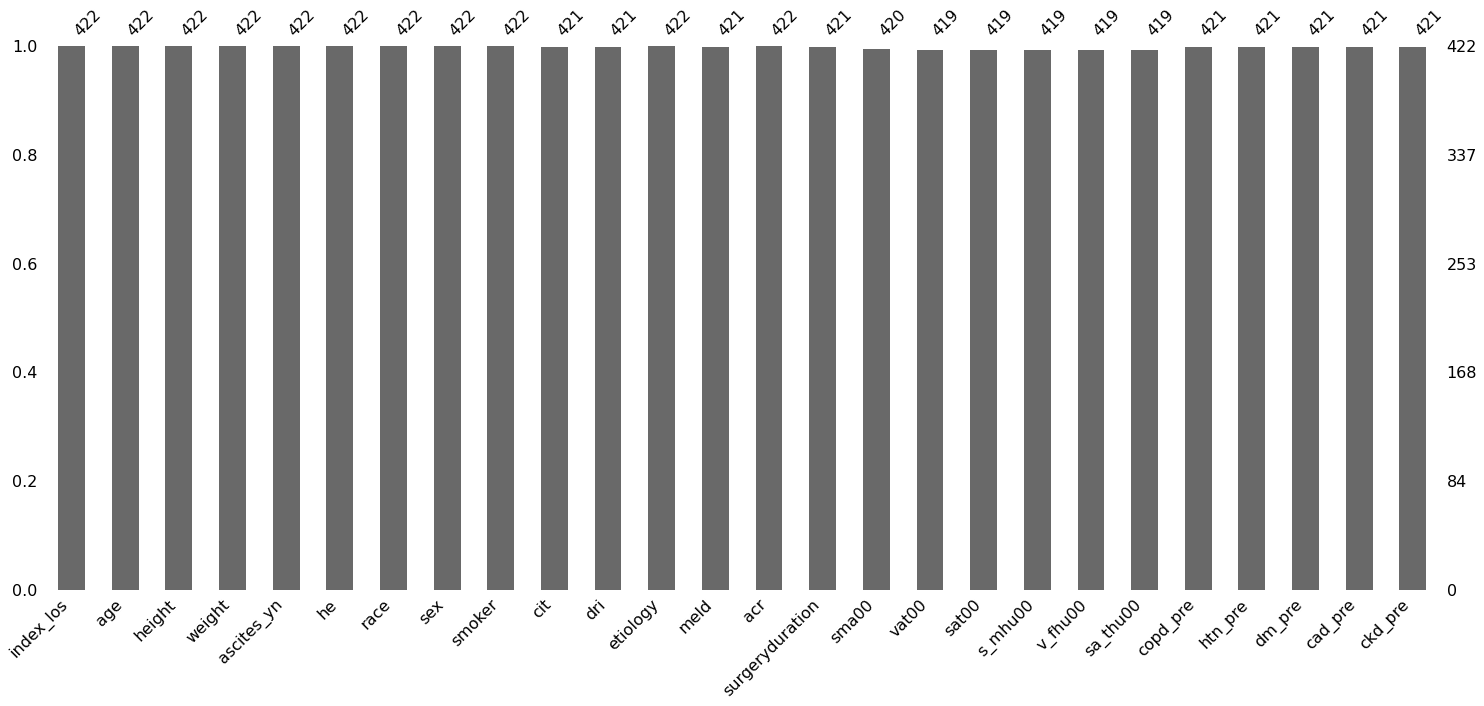

In [9]:
#!pip install missingno
import missingno as msno

msno.bar(los_data)

As we can see from this bar plot showing how many observations are non-missing, there are hardly any missing values to impute. This is really good news as hardly any of the data will end up being imputed.

<AxesSubplot:>

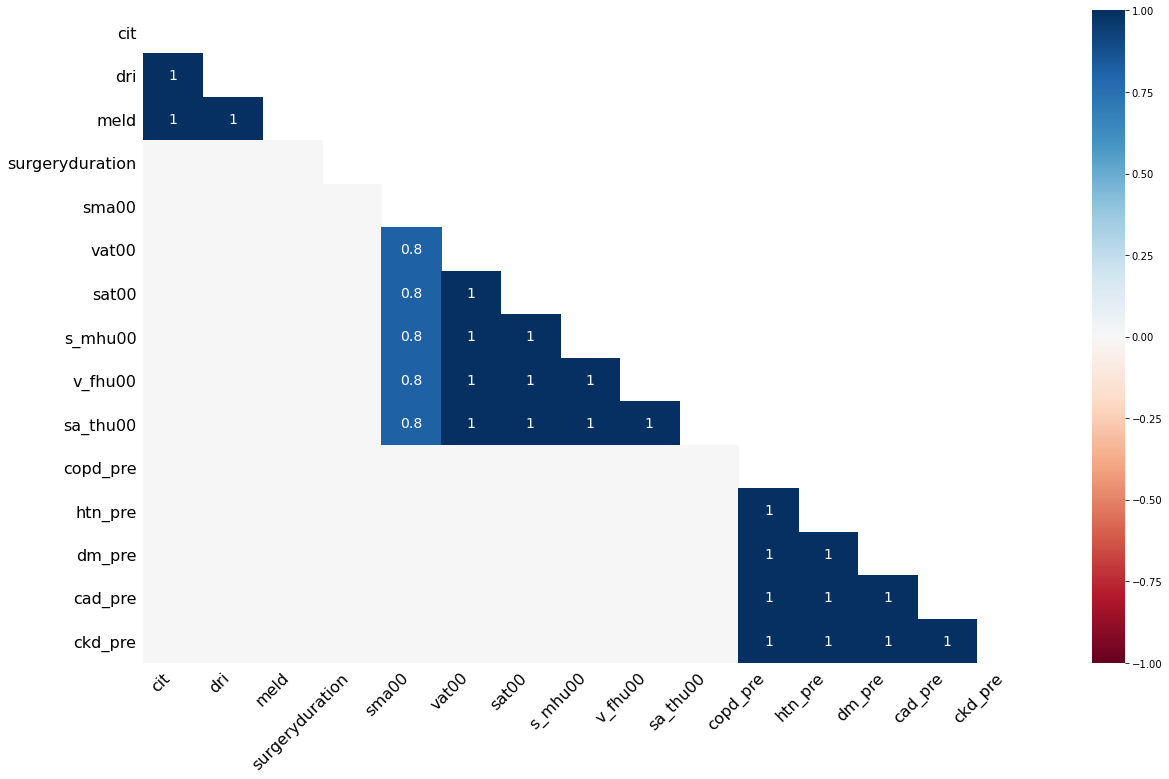

In [10]:
msno.heatmap(los_data)

Here is a heatmap showing how missing values are related. This can be used to understand what is the best way to impute missing values for different features. Due to many high correlations, this means most of these values are missing for the same patients.

<AxesSubplot:>

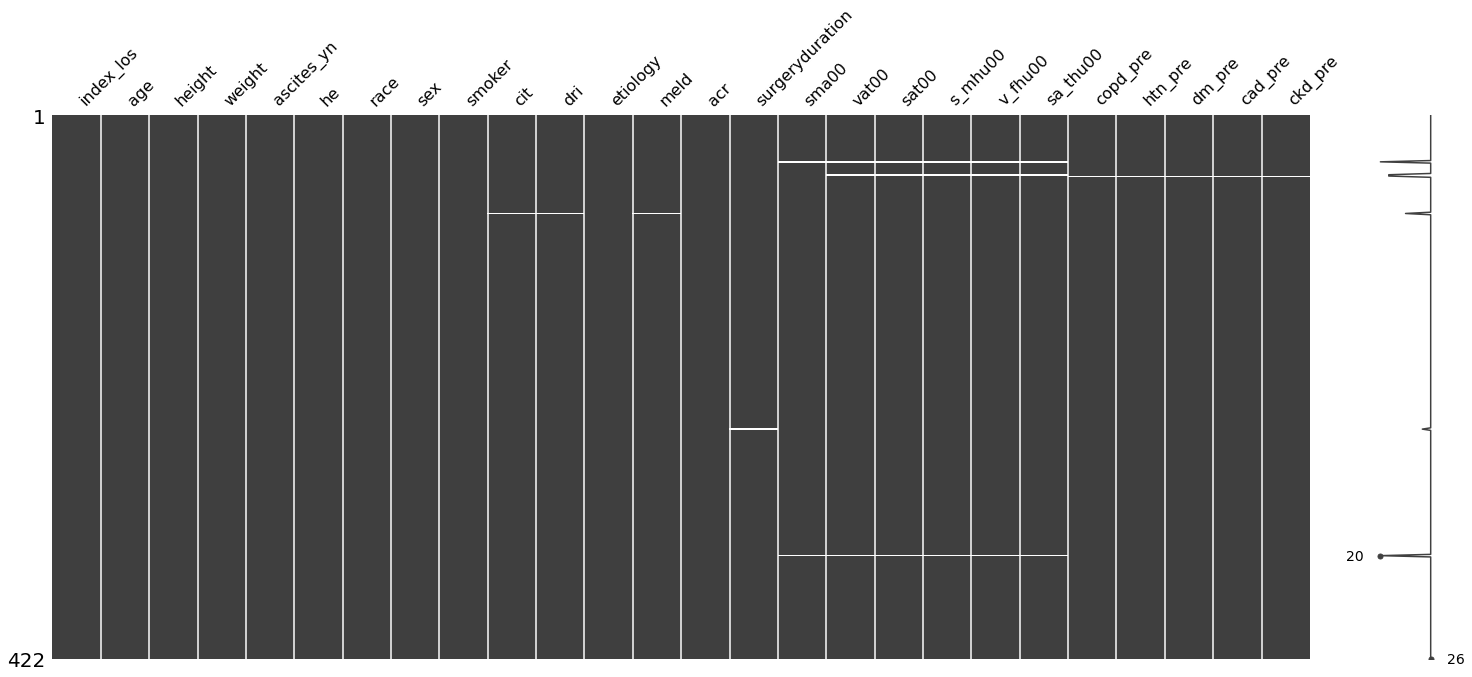

In [11]:
msno.matrix(los_data)

This matrix confirms that many of the missing values come from the same patients, especially for the body composition variables.

In [12]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=10, random_state=2022, imputation_order = 'random')
i = imp.fit_transform(los_data)

In [13]:
imputed_data = pd.DataFrame(i, columns = los_data.columns)

### Feature Scaling

In [14]:
imputed_data.dtypes

index_los          float64
age                float64
height             float64
weight             float64
ascites_yn         float64
he                 float64
race               float64
sex                float64
smoker             float64
cit                float64
dri                float64
etiology           float64
meld               float64
acr                float64
surgeryduration    float64
sma00              float64
vat00              float64
sat00              float64
s_mhu00            float64
v_fhu00            float64
sa_thu00           float64
copd_pre           float64
htn_pre            float64
dm_pre             float64
cad_pre            float64
ckd_pre            float64
dtype: object

All features are already one-hot encoded meaning all categorical variables are encoded as numerical values. This means my data is ready for modeling. I just need to split the X and Y.

In [37]:
y = imputed_data[['index_los']]
features = imputed_data.drop(['index_los'], axis = 1)

In [38]:
features.describe()

,age,height,weight,ascites_yn,he,race,sex,smoker,cit,dri,...,vat00,sat00,s_mhu00,v_fhu00,sa_thu00,copd_pre,htn_pre,dm_pre,cad_pre,ckd_pre
count,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,...,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000
mean,55.680095,172.106917,86.817235,0.808057,0.767773,0.080569,0.369668,0.111374,5.740260,0.201920,...,115.003324,232.762951,29.306173,-79.588684,-82.974323,0.035469,0.166063,0.094757,0.196995,0.066588
std,9.906428,10.346195,21.300785,0.394296,0.422755,0.272495,0.483288,0.314969,2.461373,0.323885,...,84.763138,129.196085,9.236945,8.400515,14.290294,0.185394,0.372348,0.293278,0.397859,0.249174
min,16.000000,142.240000,31.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.320000,-0.107339,...,2.484300,12.031200,7.858400,-107.159000,-114.321000,-0.032101,0.000000,-0.012407,0.000000,0.000000
25%,51.000000,165.100000,71.005000,1.000000,1.000000,0.000000,0.000000,0.000000,3.985000,0.023807,...,53.441600,137.191600,22.440075,-85.133650,-94.063150,0.000000,0.000000,0.000000,0.000000,0.000000
50%,57.000000,172.720000,85.000000,1.000000,1.000000,0.000000,0.000000,0.000000,5.390000,0.120943,...,98.257100,212.013900,29.528450,-78.449650,-84.680400,0.000000,0.000000,0.000000,0.000000,0.000000
75%,63.000000,180.340000,98.825000,1.000000,1.000000,0.000000,1.000000,0.000000,7.095000,0.280013,...,157.142500,320.859525,35.316500,-73.794075,-73.458350,0.000000,0.000000,0.000000,0.000000,0.000000
max,77.000000,203.200000,179.020000,1.000000,1.000000,1.000000,1.000000,1.000000,22.080000,3.271637,...,736.188900,658.235500,56.770300,-59.422200,-45.908700,1.000000,1.000000,1.000000,1.000000,1.000000


Due to many of the features having a large difference in range of values, I will scale the data.

In [39]:
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on features data
norm = MinMaxScaler().fit(features)

# transform features
features_norm = norm.transform(features)

In [40]:
features = pd.DataFrame(features_norm, columns = features.columns)
features.head()

,age,height,weight,ascites_yn,he,race,sex,smoker,cit,dri,...,vat00,sat00,s_mhu00,v_fhu00,sa_thu00,copd_pre,htn_pre,dm_pre,cad_pre,ckd_pre
0,0.704918,0.625000,0.423098,0.0,1.0,0.0,0.0,0.0,0.341912,0.049653,...,0.260041,0.359656,0.464049,0.684725,0.340507,0.031102,0.0,0.012255,0.0,0.0
1,0.409836,0.333333,0.290888,1.0,1.0,1.0,1.0,0.0,0.154412,0.115186,...,0.000014,0.100719,0.176391,0.809489,0.950290,0.031102,0.0,0.012255,0.0,0.0
2,0.393443,0.625000,0.374628,1.0,0.0,0.0,0.0,0.0,0.449908,0.100259,...,0.126886,0.197774,0.687418,0.521629,0.136964,0.031102,0.0,0.012255,0.0,0.0
3,0.836066,0.416667,0.381736,0.0,1.0,0.0,1.0,0.0,0.374540,0.038433,...,0.147517,0.418435,0.278787,0.548956,0.271245,0.031102,0.0,0.012255,0.0,0.0
4,0.590164,0.416667,0.247901,0.0,1.0,0.0,0.0,0.0,0.361213,0.034797,...,0.160089,0.166992,0.518649,0.372920,0.321439,0.031102,1.0,0.012255,0.0,0.0


## Modeling

Due to a small data set, I plan on using k-fold cross validation rather than splitting the data into a training and test set. This will allow me to use all the data for training. I will fit several different models and determine which has the best prediction ability based on MSE.

### Finding the Optimal K for k-fold cross validation

What value of k should I choose? I will iterate over several different values of k and compare the mse of different linear regression models to choose a k value.

In [48]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [47]:
folds = range(2,20)

for k in folds:
    cv = KFold(n_splits=k, random_state=1, shuffle=True)
    model = LinearRegression()
    scores = cross_val_score(model, features, y, scoring='neg_mean_absolute_error',
                             cv=cv, n_jobs=-1)
    print('k=%d, mse=%.3f' % (k,mean(absolute(scores))))

k=2, mse=7.392
k=3, mse=6.917
k=4, mse=6.980
k=5, mse=6.910
k=6, mse=6.918
k=7, mse=7.056
k=8, mse=6.975
k=9, mse=6.931
k=10, mse=6.911
k=11, mse=6.938
k=12, mse=6.942
k=13, mse=7.000
k=14, mse=6.961
k=15, mse=6.938
k=16, mse=6.946
k=17, mse=6.973
k=18, mse=6.937
k=19, mse=6.916


Typically, 5 or 10 folds are the most common in practice. Interestingly enough, these are exactly the two k values that performed the best in this situation. I will use 5 folds moving forward as it is slightly less complex than 10 and it will allow the number of observations in each fold to be a bit larger since I have such a small data set.

In [51]:
lr = LinearRegression()
dt_regressor = DecisionTreeRegressor(random_state = 0)
rf_regressor = RandomForestRegressor(n_estimators = 300 ,  random_state = 0)

models = np.array([lr,dt_regressor,rf_regressor])

for model in models:
    cv = KFold(n_splits=5, random_state=1, shuffle=True)
    scores = cross_val_score(model, features, y, scoring='neg_mean_absolute_error',
                             cv=cv, n_jobs=-1)
    print('mse=%.3f' % (mean(absolute(scores))))

mse=6.910
mse=9.837
mse=7.117


## Feature Importance

# A Survival Analysis of Patients post liver transplant

This is a classification problem of whether a patient is dead or alive at a certian time point post liver transplant. I will use the data to determine this time point, but I will decide based on two factors:

* The least imbalance in classes (dead or alive) while
* ensuring death is close after transplant as too far post transplant we cannot assume the death was related to the transplant

In [61]:
data['days_until_death'] = data['days_until_death'].fillna(5000)
pd.cut(data['days_until_death'], bins=[0,30,4000], labels=['dead','alive'])

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
417    NaN
418    NaN
419    NaN
420    NaN
421    NaN
Name: days_until_death, Length: 422, dtype: category
Categories (2, object): ['dead' < 'alive']

In [55]:
pd.cut(data.days_until_death, bins=[0,30,4000], labels=['dead','alive'])

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
417    NaN
418    NaN
419    NaN
420    NaN
421    NaN
Name: days_until_death, Length: 422, dtype: category
Categories (2, object): ['dead' < 'alive']

In [59]:
data['days_until_death'].max()

4078.0

In [ ]:
df['C'] = df['C'].apply(lambda x: 0 if x.strip()=='N' else 1)